<a href="https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_09_5_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# T81-558: Applications of Deep Neural Networks
**Module 9: Transfer Learning**
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), McKelvey School of Engineering, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

# Module 9 Material

* Part 9.1: Introduction to Keras Transfer Learning [[Video]](https://www.youtube.com/watch?v=AtoeoNwmd7w&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_09_1_keras_transfer.ipynb)
* Part 9.2: Keras Transfer Learning for Computer Vision [[Video]](https://www.youtube.com/watch?v=nXcz0V5SfYw&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_09_2_keras_xfer_cv.ipynb)
* Part 9.3: Transfer Learning for NLP with Keras [[Video]](https://www.youtube.com/watch?v=PyRsjwLHgAU&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_09_3_transfer_nlp.ipynb)
* Part 9.4: Transfer Learning for Facial Feature Recognition [[Video]](https://www.youtube.com/watch?v=uUZg33DfCls&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_09_4_facial_points.ipynb)
* **Part 9.5: Transfer Learning for Style Transfer** [[Video]](https://www.youtube.com/watch?v=pLWIaQwkJwU&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_09_5_style_transfer.ipynb)

# Google CoLab Instructions

The following code ensures that Google CoLab is running the correct version of TensorFlow.

In [1]:
try:
    %tensorflow_version 2.x
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Note: using Google CoLab


# Part 9.5: Transfer Learning for Keras Style Transfer

In this part, we will implement style transfer. This technique takes two images as input and produces a third. The first image is the base image that we wish to transform. The second image represents the style we want to apply to the source image. Finally, the algorithm renders a third image that emulates the style characterized by the style image. This technique is called style transfer. [[Cite:gatys2016image]](https://openaccess.thecvf.com/content_cvpr_2016/html/Gatys_Image_Style_Transfer_CVPR_2016_paper.html)

**Figure 9.STYLE_TRANS: Style Transfer**
![Style Transfer](https://data.heatonresearch.com/images/jupyter/style_trans.jpg)

I based the code presented in this part on a style transfer example in the Keras documentation created by [François Chollet](https://keras.io/examples/generative/neural_style_transfer/).

We begin by uploading two images to Colab. If running this code locally, point these two filenames at the local copies of the images you wish to use.

* **base_image_path** - The image to apply the style to.
* **style_reference_image_path** - The image whose style we wish to copy.

First, we upload the base image.

In [2]:

import os
from google.colab import files

uploaded = files.upload()

if len(uploaded) != 1:
  print("Upload exactly 1 file for source.")
else:
  for k, v in uploaded.items():
    _, ext = os.path.splitext(k)
    os.remove(k)
    base_image_path = f"source{ext}"
    open(base_image_path, 'wb').write(v)

Saving content.jpg to content.jpg


We also, upload the style image.

In [3]:
# HIDE OUTPUT
uploaded = files.upload()

if len(uploaded) != 1:
  print("Upload exactly 1 file for target.")
else:
  for k, v in uploaded.items():
    _, ext = os.path.splitext(k)
    os.remove(k)
    style_reference_image_path = f"style{ext}"
    open(style_reference_image_path, 'wb').write(v)

Saving style.jpg to style.jpg


The loss function balances three different goals defined by the following three weights. Changing these weights allows you to fine-tune the image generation.

* **total_variation_weight** - How much emphasis to place on the visual coherence of nearby pixels.
* **style_weight** - How much emphasis to place on emulating the style of the reference image.
* **content_weight** - How much emphasis to place on remaining close in appearance to the base image.

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19

result_prefix = "generated"

# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

# Dimensions of the generated picture.
width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

We now display the two images we will use, first the base image followed by the style image.

Source Image


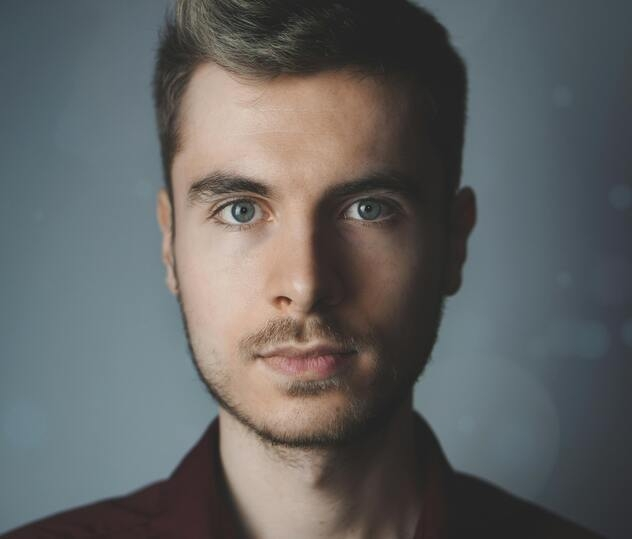

In [5]:
from IPython.display import Image, display

print("Source Image")
display(Image(base_image_path))



Style Image


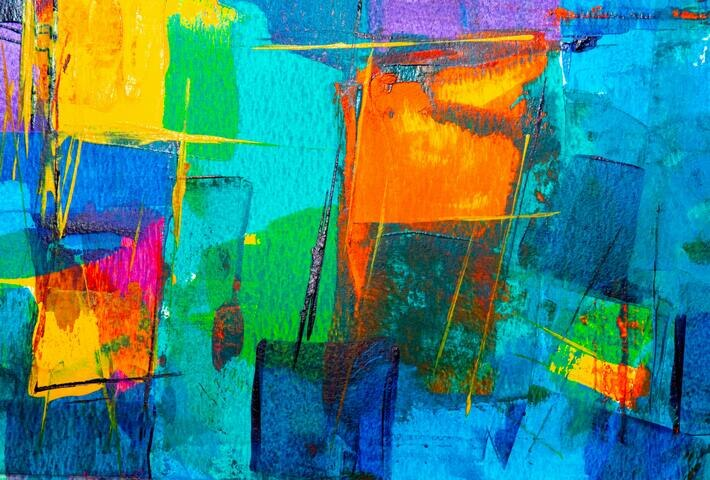

In [6]:
print("Style Image")
display(Image(style_reference_image_path))

## Image Preprocessing and Postprocessing

The preprocess_image function begins by loading the image using Keras. We scale the image to the size specified by img_nrows and img_ncols. The img_to_array  converts the image to a Numpy array, to which we add dimension to account for batching. The dimensions expected by VGG are colors depth, height, width, and batch. Finally, we convert the Numpy array to a tensor.

The deprocess_image performs the reverse, transforming the output of the style transfer process back to a regular image. First, we reshape the image to remove the batch dimension. Next, The outputs are moved back into the 0-255 range by adding the mean value of the RGB colors. We must also convert the BGR (blue, green, red) colorspace of VGG to the more standard RGB encoding.

In [8]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

## Calculating the Style, Content, and Variation Loss

Before we see how to calculate the 3-part loss function, I must introduce the Gram matrix's mathematical concept. Figure 9.GRAM demonstrates this concept.

**Figure 9.GRAM: The Gram Matrix**
![The Gram Matrix](https://data.heatonresearch.com/images/jupyter/gram.jpg)

We calculate the Gram matrix by multiplying a matrix by its transpose. To calculate two parts of the loss function, we will take the Gram matrix of the outputs from several convolution layers in the VGG network. To determine both style, and similarity to the original image, we will compare the convolution layer output of VGG rather than directly comparing the image pixels. In the third part of the loss function, we will directly compare pixels near each other.

Because we are taking convolution output from several different levels of the VGG network, the Gram matrix provides a means of combining these layers. The Gram matrix of the VGG convolution layers represents the style of the image. We will calculate this style for the original image, the style-reference image, and the final output image as the algorithm generates it.



In [10]:
# The gram matrix of an image tensor (feature-wise outer product)
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# The "style loss" is designed to maintain the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of feature maps from the style reference image and from the generated image
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) /\
      (4.0 * (channels ** 2) * (size ** 2))


# An auxiliary loss function
# designed to maintain the "content" of the base image in the generated image
def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# The 3rd loss function, total variation loss, designed to keep the generated image locally coherent
def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] \
          - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] \
          - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

The style_loss function compares how closely the current generated image (combination) matches the style of the reference style image. The Gram matrixes of the style and current generated image are subtracted and normalized to calculate this difference in style. Precisely, it consists in a sum of L2 distances between the Gram matrices of the representations of the base image and the style reference image, extracted from different layers of VGG. The general idea is to capture color/texture information at different spatial scales (fairly large scales, as defined by the depth of the layer considered).

The content_loss function compares how closely the current generated image matches the original image. You must subtract Gram matrixes of the original and generated images to calculate this difference. Here we calculate the L2 distance between the base image's VGG features and the generated image's features, keeping the generated image close enough to the original one.

Finally, the total_variation_loss function imposes local spatial continuity between the pixels of the generated image, giving it visual coherence.

## The VGG Neural Network

VGG19 is a convolutional neural network model proposed by K. Simonyan and A. Zisserman. [[Cite:simonyan2014very]](https://arxiv.org/abs/1409.1556) The model achieves 92.7% top-5 test accuracy in ImageNet, a dataset of over 14 million images belonging to 1000 classes. We will transfer the VGG16 weights into our style transfer model. Keras provides functions to load the VGG neural network.

In [11]:

# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

80134624/80134624 [==============================] - 0s 0us/step


We can now generate the complete loss function. The following images are input to the compute_loss function:

* **combination_image** - The current iteration of the generated image.
* **base_image** - The starting image.
* **style_reference_image** - The image that holds the style to reproduce.

The layers specified by style_layer_names indicate which layers should be extracted as features from VGG for each of the three images.

In [12]:
# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * \
      total_variation_loss(combination_image)
    return loss

## Generating the Style Transferred Image

The compute_loss_and_grads function calls the loss function and computes the gradients. The parameters of this model are the actual RGB values of the current iteration of the generated images. These parameters start with the base image, and the algorithm optimizes them to the final rendered image. We are not training a model to perform the transformation; we are training/modifying the image to minimize the loss functions. We utilize gradient tape to allow Keras to modify the image in the same way the neural network training modifies weights.

In [13]:
@tf.function
def compute_loss_and_grads(combination_image, \
                  base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, \
                base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

We can now optimize the image according to the loss function.

In [ ]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 300
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)

Iteration 100: loss=7199.92
Iteration 200: loss=5699.73


We can display the image.

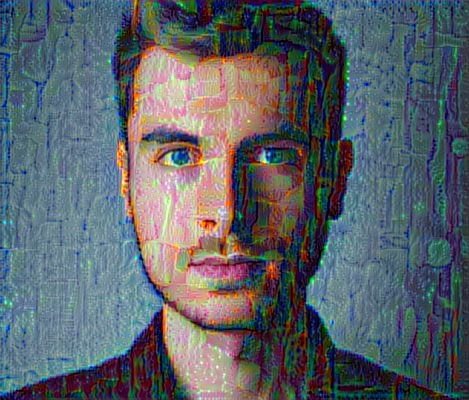

In [ ]:
display(Image(result_prefix + "_at_iteration_300.png"))

We can download this image.

In [ ]:
# HIDE OUTPUT
from google.colab import files
files.download(result_prefix + "_at_iteration_300.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>